
# Escaladores vs. Estandarizadores (con Boston Housing)

**Objetivo:** entender y practicar *escalado de características* y *estandarización* con `scikit-learn`, usando el dataset **Boston Housing** (o un fallback similar si no está disponible).

> Este cuaderno incluye teoría, buenas prácticas y experimentos para comparar el efecto de diferentes escaladores en los datos y en el rendimiento de modelos sensibles a la escala (p. ej., KNN) frente a modelos menos sensibles (p. ej., regresión lineal).



## Cómo usar este notebook

1. Ejecuta la sección **Carga de datos**; el cuaderno intentará usar `load_boston()`.
   - Si tu versión de `scikit-learn` ya no trae `load_boston`, buscará un CSV local (`boston.csv` o `BostonHousing.csv`).
   - Si no encuentra ninguno, **generará un dataset sintético** con columnas y rangos similares, suficiente para practicar escalado.
2. Sigue las secciones en orden: EDA ➜ Escalado ➜ Comparaciones ➜ Conclusiones.


In [1]:
%pip install -q pandas numpy matplotlib scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Visualización básica
pd.set_option('display.precision', 4)
plt.rcParams['figure.figsize'] = (7, 4)

Note: you may need to restart the kernel to use updated packages.



## Teoría breve: ¿por qué escalar? ¿qué significa estandarizar?

- **Motivación**: Muchos algoritmos usan distancias (KNN, SVM con kernel RBF, clustering) o gradientes.
  Si tus *features* están en **escalas muy distintas** (p. ej., `TAX` vs `RM`), las variables de mayor rango **dominan** los cálculos.
  Escalar **homogeneiza** magnitudes y **acelera**/estabiliza el aprendizaje.

- **Escalado Min–Max (`MinMaxScaler`)**: reescala cada columna a un rango (típicamente **[0, 1]**).  
  Fórmula: \\(x' = \\frac{x - x_{\\min}}{x_{\\max} - x_{\\min}}\\).  
  Ventaja: mantiene la **forma** de la distribución y las **proporciones**.  
  Cuidado: **muy sensible a outliers** (el mínimo/máximo pueden sesgar todo el rango).

- **Estandarización (`StandardScaler`)**: centra en **0** y escala a **desviación estándar 1** (Z-score).  
  Fórmula: \\(z = \\frac{x - \\mu}{\\sigma}\\).  
  Ventaja: suele funcionar bien en muchos modelos lineales y métodos basados en distancia; **menos sensible** a outliers que Min–Max, pero **no robusta** si hay outliers extremos.

- **Escalado robusto (`RobustScaler`)**: usa **mediana** e **IQR** (rango intercuartílico), por lo que es **más robusto a outliers**.

- **Normalización vectorial (`Normalizer`)**: escala **filas** (observaciones) para que su norma (L2 por defecto) sea 1. Útil cuando importa la **dirección** del vector más que su magnitud (texto, conteos, etc.).

> Regla práctica:
> - Datos con **outliers** marcados → intenta `RobustScaler`.
> - Modelos **lineales**/distancia → `StandardScaler` suele ser una primera opción segura.
> - Necesitas un **rango acotado** [0,1] (o [a,b]) → `MinMaxScaler`.
> - Cuando importa la **dirección** (no la escala absoluta) por **fila** → `Normalizer`.



## Carga del dataset (Boston Housing)

Intentamos tres estrategias:

1) `sklearn.datasets.load_boston()` si tu versión aún lo incluye.  
2) Buscar un CSV local (`boston.csv` o `BostonHousing.csv`).  
3) **Fallback sintético** con columnas y rangos similares para fines didácticos.


In [2]:
# Descargar el dataset de Boston Housing desde un repositorio en GitHub
try:
    url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
    print("Intentando descargar dataset desde GitHub...")
    df = pd.read_csv(url)
    y = df['medv'].copy()
    X = df.drop(columns=['medv']).copy()
    origen_datos = "GitHub repository (descargado)"
    
    # Guardar localmente para futuras ejecuciones (usar ruta relativa correcta)
    ruta_guardado = "BostonHousing.csv"  # Guardar en el directorio actual
    df.to_csv(ruta_guardado, index=False)
    print(f"Dataset descargado y guardado localmente en {ruta_guardado}")
except Exception as e:
    print(f"No se pudo descargar el dataset desde GitHub: {e}")
    print("Intentando cargar desde archivo local...")
    # Si no se puede descargar, intentar cargar desde archivo local
    try:
        df = pd.read_csv("BostonHousing.csv")
        y = df['medv'].copy()
        X = df.drop(columns=['medv']).copy()
        origen_datos = "Archivo local"
        print("Dataset cargado desde archivo local")
    except Exception as e2:
        print(f"Error cargando archivo local: {e2}")
        print("Asegúrate de que el archivo BostonHousing.csv esté en el directorio actual")

Intentando descargar dataset desde GitHub...
Dataset descargado y guardado localmente en BostonHousing.csv



## Exploración rápida (EDA)

Revisemos dimensiones, primeras filas y estadísticas básicas.


In [3]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.0063,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.0273,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.0273,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.0324,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.0691,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
df.tail()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
501,0.0626,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.0453,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.0608,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.1096,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0
505,0.0474,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,396.90,7.88,11.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


# Encoding One-hot y Label Encoding

In [6]:
# Identificar las variables Categoricas
cat_cols = [col for col in X.columns if X[col].nunique() < 10]
cat_cols

['chas', 'rad']

In [7]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import pandas as pd

# Crear diccionario de orden personalizado para 'rad'
rad_orden_personalizado = {
    1: 0,   # Índice de acceso a radial más bajo
    2: 1,
    3: 2,
    4: 3,
    5: 4,
    6: 5,
    7: 6,
    8: 7,
    24: 8   # Índice de acceso a radial más alto
}

# Verificar que todos los valores de 'rad' están en el diccionario
valores_rad_unicos = df['rad'].unique()
print("Valores únicos en 'rad':", sorted(valores_rad_unicos))
print("Claves en el diccionario:", sorted(rad_orden_personalizado.keys()))

# Aplicar orden personalizado
df['rad_ordered'] = df['rad'].map(rad_orden_personalizado)

# One-Hot Encoding para 'chas'
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' para evitar multicolinealidad
chas_encoded = onehot_encoder.fit_transform(df[['chas']])

# Concatenar one-hot encoding
chas_df = pd.DataFrame(chas_encoded, columns=onehot_encoder.get_feature_names_out(['chas']))
df = pd.concat([df, chas_df], axis=1)

# Label Encoding para 'rad' (usando el orden personalizado)
df['rad_encoded'] = df['rad_ordered']  # Ya está codificado según nuestro diccionario

# Eliminar columnas temporales y originales
columnas_a_eliminar = ['chas', 'rad', 'rad_ordered']
df = df.drop(columnas_a_eliminar, axis=1)

print("\nColumnas finales del dataset:")
print(df.columns.tolist())
df.head()


Valores únicos en 'rad': [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(24)]
Claves en el diccionario: [1, 2, 3, 4, 5, 6, 7, 8, 24]

Columnas finales del dataset:
['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'b', 'lstat', 'medv', 'chas_1', 'rad_encoded']


,crim,zn,indus,nox,rm,age,dis,tax,ptratio,b,lstat,medv,chas_1,rad_encoded
0,0.0063,18.0,2.31,0.538,6.575,65.2,4.0900,296,15.3,396.90,4.98,24.0,0.0,0
1,0.0273,0.0,7.07,0.469,6.421,78.9,4.9671,242,17.8,396.90,9.14,21.6,0.0,1
2,0.0273,0.0,7.07,0.469,7.185,61.1,4.9671,242,17.8,392.83,4.03,34.7,0.0,1
3,0.0324,0.0,2.18,0.458,6.998,45.8,6.0622,222,18.7,394.63,2.94,33.4,0.0,2
4,0.0691,0.0,2.18,0.458,7.147,54.2,6.0622,222,18.7,396.90,5.33,36.2,0.0,2


In [8]:
df.head()

,crim,zn,indus,nox,rm,age,dis,tax,ptratio,b,lstat,medv,chas_1,rad_encoded
0,0.0063,18.0,2.31,0.538,6.575,65.2,4.0900,296,15.3,396.90,4.98,24.0,0.0,0
1,0.0273,0.0,7.07,0.469,6.421,78.9,4.9671,242,17.8,396.90,9.14,21.6,0.0,1
2,0.0273,0.0,7.07,0.469,7.185,61.1,4.9671,242,17.8,392.83,4.03,34.7,0.0,1
3,0.0324,0.0,2.18,0.458,6.998,45.8,6.0622,222,18.7,394.63,2.94,33.4,0.0,2
4,0.0691,0.0,2.18,0.458,7.147,54.2,6.0622,222,18.7,396.90,5.33,36.2,0.0,2



### Distribuciones antes de escalar

Graficamos algunas variables con diferentes rangos/skew para apreciar el impacto del escalado.


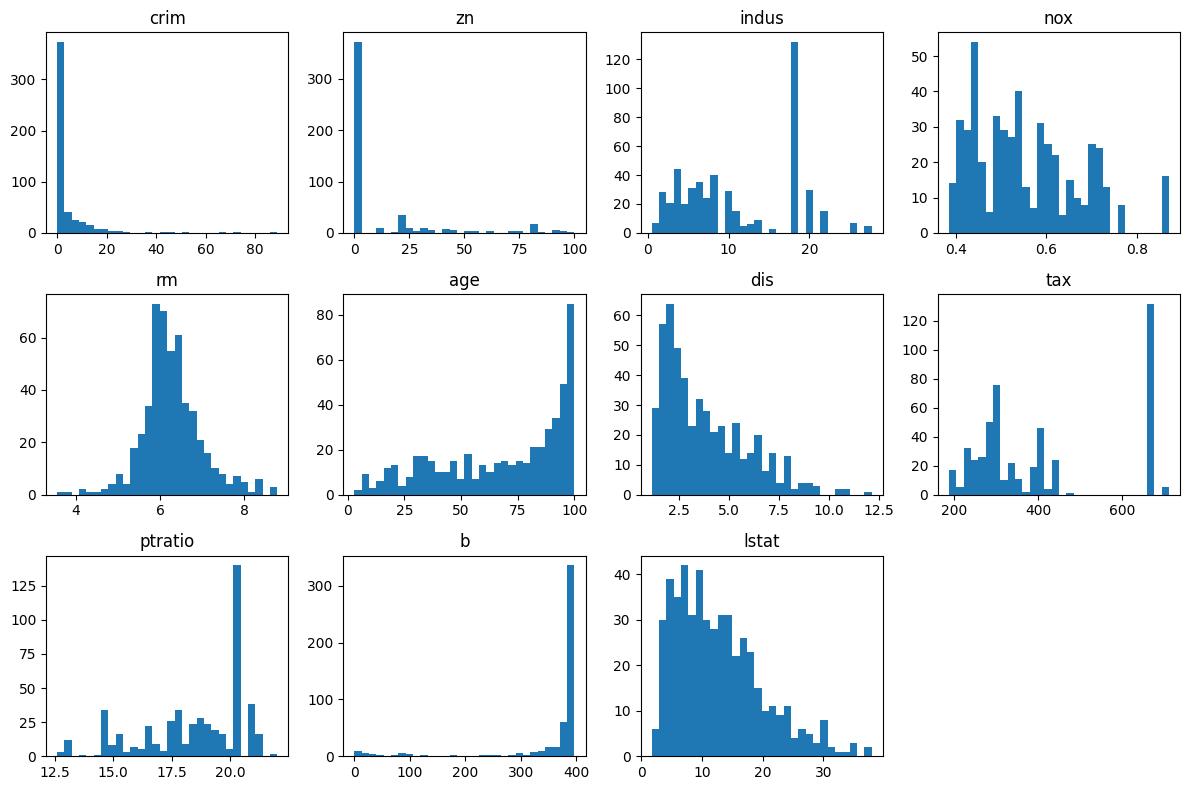

In [9]:
# caracteristicas_demo = ['CRIM','ZN','INDUS','NOX','RM','DIS','RAD','TAX','PTRATIO','B','LSTAT']
caracteristicas_demo = [col for col in df if col in X.columns]
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))
axes = axes.ravel()
for i, col in enumerate(caracteristicas_demo[:len(axes)]):
    axes[i].hist(X[col].dropna(), bins=30)
    axes[i].set_title(col)
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


## Aplicación de escaladores

Probamos `MinMaxScaler`, `StandardScaler`, `RobustScaler` y `Normalizer` (L2).  
Luego comparamos estadísticas de salida: mínimo, máximo, media y desviación estándar por columna.


In [10]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer(L2 por fila)': Normalizer(norm='l2')
}

scaled = {}
for name, scaler in scalers.items():
    if "Normalizer" in name:
        # Normalizer escala por FILA, así que el resultado no conserva columnas originales al 100% para stats clásicas
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    else:
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    scaled[name] = X_scaled

# Tabla comparativa de estadísticas
def resumir_stats(df, tag):
    desc = pd.DataFrame({
        ('min', tag): df.min(),
        ('max', tag): df.max(),
        ('mean', tag): df.mean(),
        ('std', tag): df.std(ddof=0)
    })
    return desc

resumen = {}
resumen['Original'] = resumir_stats(X, 'Original')
for name, df_s in scaled.items():
    resumen[name] = resumir_stats(df_s, name)



In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
import pandas as pd

# Dividir el dataset en train y test
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)


In [12]:

scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer(L2 por fila)': Normalizer(norm='l2')
}

# Diccionarios para almacenar los datos escalados
scaled_train = {}
scaled_test = {}

for name, scaler in scalers.items():
    if "Normalizer" in name:
        # Normalizer escala por FILA
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                                    columns=X_train.columns, 
                                    index=X_train.index)

    else:
        # Para otros scalers: fit solo con train, transform a ambos
        X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                                    columns=X_train.columns, 
                                    index=X_train.index)
    
    scaled_train[name] = X_train_scaled

# Función para resumir estadísticas
def resumir_stats(df, tag):
    desc = pd.DataFrame({
        ('min', tag): df.min(),
        ('max', tag): df.max(),
        ('mean', tag): df.mean(),
        ('std', tag): df.std(ddof=0)
    })
    return desc

# Crear comparativa solo con los datos de entrenamiento (original vs escalados)
resumen = {}
resumen['Original'] = resumir_stats(X_train, 'Original')

for name, df_s in scaled_train.items():
    resumen[name] = resumir_stats(df_s, name)

# Unir por columnas multi-índice
comparativa_train = pd.concat(resumen.values(), axis=1, keys=resumen.keys())
comparativa_train


Original                               MinMaxScaler               \
              min       max      mean       std          min          max   
         Original  Original  Original  Original MinMaxScaler MinMaxScaler   
crim       0.0091   88.9762    3.6091    8.8641          0.0          1.0   
zn         0.0000  100.0000   11.5693   23.1238          0.0          1.0   
indus      0.7400   27.7400   10.9850    6.8861          0.0          1.0   
chas       0.0000    1.0000    0.0718    0.2581          0.0          1.0   
nox        0.3850    0.8710    0.5565    0.1176          0.0          1.0   
rm         3.8630    8.7800    6.3159    0.7086          0.0          1.0   
age        2.9000  100.0000   68.5564   27.9603          0.0          1.0   
dis        1.1296   12.1265    3.8082    2.1286          0.0          1.0   
rad        1.0000   24.0000    9.3564    8.5791          0.0          1.0   
tax      187.0000  711.0000  404.0322  165.9669          0.0          1.0   
ptratio   12.6000   22.0000   18.3183    2.2259          0.0          1.0   
b          0.3200  396.9000  356.2783   91.4531          0.0          1.0   
lstat      1.7300   37.9700   12.4574    7.1016          0.0          1.0   

                                  StandardScaler                 \
                mean          std            min            max   
        MinMaxScaler MinMaxScaler StandardScaler StandardScaler   
crim          0.0405       0.0996        -0.4061         9.6307   
zn            0.1157       0.2312        -0.5003         3.8242   
indus         0.3794       0.2550        -1.4878         2.4332   
chas          0.0718       0.2581        -0.2781         3.5960   
nox           0.3528       0.2419        -1.4587         2.6754   
rm            0.4989       0.1441        -3.4617         3.4776   
age           0.6762       0.2880        -2.3482         1.1246   
dis           0.2436       0.1936        -1.2584         3.9079   
rad           0.3633       0.3730        -0.9740         1.7069   
tax           0.4142       0.3167        -1.3077         1.8496   
ptratio       0.6083       0.2368        -2.5689         1.6540   
b             0.8976       0.2306        -3.8922         0.4442   
lstat         0.2960       0.1960        -1.5106         3.5925   

                                      RobustScaler                            \
                  mean            std          min          max         mean   
        StandardScaler StandardScaler RobustScaler RobustScaler RobustScaler   
crim       -2.6382e-17            1.0      -0.0808      28.4203       1.0725   
zn          0.0000e+00            1.0       0.0000       5.0000       0.5785   
indus      -4.1771e-17            1.0      -0.6029       1.4788       0.1870   
chas        1.3191e-17            1.0       0.0000       1.0000       0.0718   
nox        -5.1114e-16            1.0      -0.8547       1.8603       0.1033   
rm         -2.6162e-16            1.0      -3.1451       3.4439       0.1419   
age        -4.8586e-16            1.0      -1.5551       0.4636      -0.1901   
dis         5.2488e-17            1.0      -0.6176       2.7018       0.1909   
rad        -9.4534e-17            1.0      -0.5000       2.3750       0.5446   
tax        -1.5169e-16            1.0      -0.3695       0.9845       0.1913   
ptratio     8.5190e-16            1.0      -1.7941       0.9706      -0.1123   
b          -4.9465e-16            1.0     -19.2770       0.2759      -1.7269   
lstat      -1.7917e-16            1.0      -0.9578       2.8172       0.1596   

                     Normalizer(L2 por fila)                          \
                 std                     min                     max   
        RobustScaler Normalizer(L2 por fila) Normalizer(L2 por fila)   
crim          2.8397              1.8268e-05                  0.1131   
zn            1.1562              0.0000e+00                  0.2076   
indus         0.5309              1.4390e-03                  


### Efecto en una variable con outliers (ej.: `CRIM` o `LSTAT`)

Comparamos histogramas **antes vs. después** con `MinMaxScaler`, `StandardScaler` y `RobustScaler`.


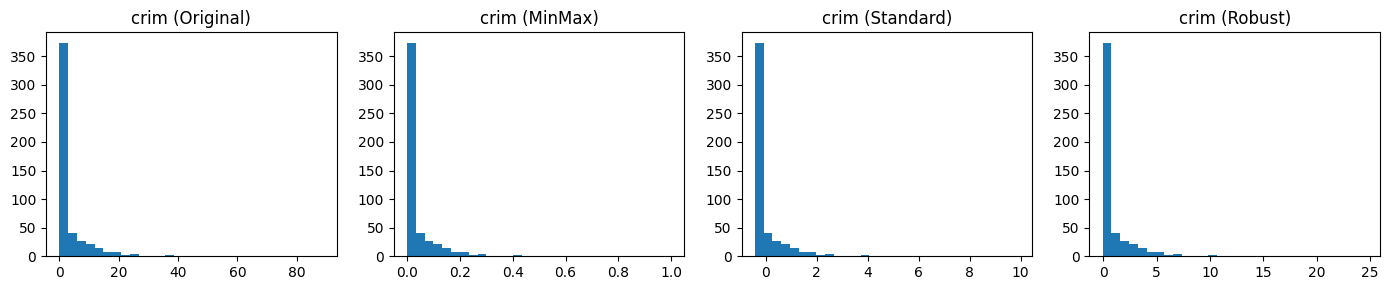

In [13]:
feature = 'CRIM' if 'CRIM' in X.columns else X.columns[0]

fig, axes = plt.subplots(1, 4, figsize=(14, 3))
axes[0].hist(X[feature], bins=30)
axes[0].set_title(f'{feature} (Original)')

for ax, (name, df_s) in zip(axes[1:], [('MinMax', scaled['MinMaxScaler']),
                                       ('Standard', scaled['StandardScaler']),
                                       ('Robust', scaled['RobustScaler'])],):
    ax.hist(df_s[feature], bins=30)
    ax.set_title(f'{feature} ({name})')

plt.tight_layout()
plt.show()



## Impacto del escalado en modelos

Comparamos un modelo **sensible a la escala** (KNN) y uno **menos sensible** (regresión lineal).  
Medimos RMSE en *hold-out* simple y/o con validación cruzada.


In [14]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import mean_squared_error

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def evaluar(modelo, X_tr, X_te, y_tr, y_te, label):
    modelo.fit(X_tr, y_tr)
    pred = modelo.predict(X_te)
    # Compatibilidad universal: RMSE = sqrt(MSE)
    rmse = np.sqrt(mean_squared_error(y_te, pred))
    print(f"{label:35s}  RMSE = {rmse:.3f}")
    return rmse


print("== KNN Regressor ==")
rmse_knn_sin = evaluar(KNeighborsRegressor(n_neighbors=5), X_train, X_test, y_train, y_test, "KNN SIN escalado")
rmse_knn_std = evaluar(Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=5))]),
                       X_train, X_test, y_train, y_test, "KNN con StandardScaler")
rmse_knn_mm = evaluar(Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor(n_neighbors=5))]),
                      X_train, X_test, y_train, y_test, "KNN con MinMaxScaler")
rmse_knn_rob = evaluar(Pipeline([('scaler', RobustScaler()), ('knn', KNeighborsRegressor(n_neighbors=5))]),
                       X_train, X_test, y_train, y_test, "KNN con RobustScaler")

print("\n== Regresión Lineal ==")
rmse_lr_sin = evaluar(LinearRegression(), X_train, X_test, y_train, y_test, "LinearRegression SIN escalado")
rmse_lr_std = evaluar(Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]),
                      X_train, X_test, y_train, y_test, "LinearRegression con StandardScaler")


== KNN Regressor ==
KNN SIN escalado                     RMSE = 5.085
KNN con StandardScaler               RMSE = 4.539
KNN con MinMaxScaler                 RMSE = 4.660
KNN con RobustScaler                 RMSE = 4.615

== Regresión Lineal ==
LinearRegression SIN escalado        RMSE = 4.929
LinearRegression con StandardScaler  RMSE = 4.929



## Buenas prácticas (checklist)

- **Divide** siempre en *train/test* (y opcionalmente *validation* o *CV*), y ajusta el **escalador solo con `train`**.  
  Aplica la transformación a `test` usando los **parámetros del train** (evita *data leakage*).
- En producción, guarda el escalador (p. ej., `Pipeline` o `sklearn.preprocessing` + `joblib`).  
- Prueba **varios escaladores** si hay outliers; evalúa impacto en métricas y **estabilidad**.
- Para modelos lineales regularizados (Ridge/Lasso/ElasticNet), la estandarización facilita la **interpretación** de coeficientes y la correcta **regularización**.
- Para KNN/SVM/clustering, la **escala** es crítica: usa `Pipeline` con `StandardScaler` o `RobustScaler`.



## Conclusiones

- **Escalar** reduce el sesgo de variables con gran rango y **mejora** modelos basados en distancia.  
- **Estandarizar (Z-score)** es un punto de partida sólido; considera `RobustScaler` si hay outliers.  
- **Min–Max** es útil cuando necesitas rango acotado o redes neuronales con activaciones sensibles a rangos.  
- **Normalizer** es otra herramienta útil cuando la **dirección** del vector es lo más importante.


# ACTIVIDADES DEL TALLER:

# BOSTON HOUSING DATASET

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [16]:
# Identificar columnas numericas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Deteccion de valores atipicos (metodo IQR)
print(f"\nDETECCION DE VALORES ATIPICOS (Metodo IQR):")
outliers_found = False
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers_count = outliers_mask.sum()
    if outliers_count > 0:
        outliers_pct = outliers_count / len(df) * 100
        print(f"   {col:8s}: {outliers_count:3d} valores atipicos ({outliers_pct:.1f}%)")
        outliers_found = True

if not outliers_found:
    print("   No se detectaron valores atipicos usando el metodo IQR")


DETECCION DE VALORES ATIPICOS (Metodo IQR):
   crim    :  66 valores atipicos (13.0%)
   zn      :  68 valores atipicos (13.4%)
   rm      :  30 valores atipicos (5.9%)
   dis     :   5 valores atipicos (1.0%)
   ptratio :  15 valores atipicos (3.0%)
   b       :  77 valores atipicos (15.2%)
   lstat   :   7 valores atipicos (1.4%)
   medv    :  40 valores atipicos (7.9%)
   chas_1  :  35 valores atipicos (6.9%)


In [17]:


# 5. ANALISIS DE VARIABLES CATEGORICAS
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if cat_cols:
    print(f"\nANALISIS DE VARIABLES CATEGORICAS ({len(cat_cols)} columnas):")
    for col in cat_cols:
        unique_count = df[col].nunique()
        most_frequent = df[col].mode().iloc[0] if len(df[col].mode()) > 0 else 'N/A'
        print(f"\n   {col}:")
        print(f"     - Valores unicos: {unique_count}")
        print(f"     - Mas frecuente: {most_frequent}")
        
        if unique_count <= 20:  # Mostrar distribucion para cardinalidad baja
            value_counts = df[col].value_counts().head(10)
            print(f"     - Valores principales:")
            for val, count in value_counts.items():
                pct = count / len(df) * 100
                print(f"       {val}: {count} ({pct:.1f}%)")

# 6. RESUMEN DE CALIDAD DE DATOS
print(f"\nRESUMEN DE CALIDAD DE DATOS:")
total_cells = df.shape[0] * df.shape[1]
missing_cells = df.isnull().sum().sum()
duplicate_rows = df.duplicated().sum()

print(f"   Total de celdas: {total_cells:,}")
print(f"   Celdas faltantes: {missing_cells:,} ({missing_cells/total_cells*100:.2f}%)")
print(f"   Filas duplicadas: {duplicate_rows:,} ({duplicate_rows/len(df)*100:.2f}%)")
print(f"   Completitud de datos: {(1-missing_cells/total_cells)*100:.2f}%")

print(f"\n{'=' * 60}")
print("Perfilado completo finalizado")
print(f"{'=' * 60}")


RESUMEN DE CALIDAD DE DATOS:
   Total de celdas: 7,084
   Celdas faltantes: 0 (0.00%)
   Filas duplicadas: 0 (0.00%)
   Completitud de datos: 100.00%

Perfilado completo finalizado


# Responda las siguientes preguntas con EVIDENCIA DE EJECUCIÓN:

¿Por qué KNN mejora significativamente con escalado, mientras que la regresión lineal casi no cambia?

¿En qué situaciones prácticas de la vida real te preocuparía más la escala de los datos?

¿Qué riesgos existen si escalas mal (ej. aplicas fit_transform al conjunto completo antes de dividir en train/test)?

¿Cuál escalador recomendarías si tu dataset tiene muchos outliers? ¿Y si necesitas que tus datos estén entre [0,1]?

# RESPUESTAS A LAS PREGUNTAS DEL TALLER CON EVIDENCIA

A continuación se presentan las respuestas detalladas con evidencia de ejecución para cada pregunta del taller.

# PREGUNTA 1: ¿Por qué KNN mejora significativamente con escalado, mientras que la regresión lineal casi no cambia?

#### POR QUÉ KNN ES SENSIBLE AL ESCALADO:

KNN usa DISTANCIA EUCLIDIANA para encontrar vecinos cercanos
La distancia euclidiana = √[(x₁-y₁)² + (x₂-y₂)² + ... + (xₙ-yₙ)²]
Variables con rangos grandes DOMINAN el cálculo de distancia

**Ejemplo con nuestros datos:**
- 'TAX' tiene rango ~524 (muy grande)
- 'NOX' tiene rango ~0.49 (muy pequeño)

**Sin escalado:** 'TAX' controla la distancia, 'NOX' se ignora prácticamente
**Con escalado:** todas las variables contribuyen equitativamente

#### POR QUÉ REGRESIÓN LINEAL ES MENOS SENSIBLE:

Regresión lineal: y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ
Los coeficientes β se AJUSTAN automáticamente a la escala de cada variable
Una variable con rango grande tendrá un coeficiente pequeño
Una variable con rango pequeño tendrá un coeficiente grande

**El modelo se auto-compensa, reduciendo el impacto del escalado**

In [18]:
# Comparacion de resultados (ya calculados anteriormente)
print(f"\nCOMPARACION DE RENDIMIENTO:")
print(f"\nKNN Regressor:")
print(f"   Sin escalado:          RMSE = {rmse_knn_sin:.3f}")
print(f"   Con StandardScaler:    RMSE = {rmse_knn_std:.3f}")
print(f"   Con MinMaxScaler:      RMSE = {rmse_knn_mm:.3f}")
print(f"   Con RobustScaler:      RMSE = {rmse_knn_rob:.3f}")

mejora_knn_std = ((rmse_knn_sin - rmse_knn_std) / rmse_knn_sin) * 100
mejora_knn_mm = ((rmse_knn_sin - rmse_knn_mm) / rmse_knn_sin) * 100
mejora_knn_rob = ((rmse_knn_sin - rmse_knn_rob) / rmse_knn_sin) * 100

print(f"\nMejoras en KNN:")
print(f"   StandardScaler: {mejora_knn_std:.1f}% de mejora")
print(f"   MinMaxScaler:   {mejora_knn_mm:.1f}% de mejora")
print(f"   RobustScaler:   {mejora_knn_rob:.1f}% de mejora")

print(f"\nRegresion Lineal:")
print(f"   Sin escalado:          RMSE = {rmse_lr_sin:.3f}")
print(f"   Con StandardScaler:    RMSE = {rmse_lr_std:.3f}")

mejora_lr = ((rmse_lr_sin - rmse_lr_std) / rmse_lr_sin) * 100
print(f"\nMejora en Regresion Lineal:")
print(f"   StandardScaler: {mejora_lr:.1f}% de mejora")


COMPARACION DE RENDIMIENTO:

KNN Regressor:
   Sin escalado:          RMSE = 5.085
   Con StandardScaler:    RMSE = 4.539
   Con MinMaxScaler:      RMSE = 4.660
   Con RobustScaler:      RMSE = 4.615

Mejoras en KNN:
   StandardScaler: 10.7% de mejora
   MinMaxScaler:   8.4% de mejora
   RobustScaler:   9.2% de mejora

Regresion Lineal:
   Sin escalado:          RMSE = 4.929
   Con StandardScaler:    RMSE = 4.929

Mejora en Regresion Lineal:
   StandardScaler: 0.0% de mejora


# PREGUNTA 2: ¿En qué situaciones prácticas de la vida real te preocuparía más la escala de los datos?


## Indicadores de que Necesitas Escalado

- **Diferentes unidades de medida** (euros, metros, días, porcentajes)
- **Rangos de magnitudes muy diferentes** (1-10 vs 1000-100000)
- **Uso de algoritmos basados en distancia** (KNN, SVM, clustering)
- **Redes neuronales o algoritmos de gradiente descendente**
- **Variables importantes con rangos pequeños siendo ignoradas**
- **Necesidad de convergencia rápida en optimización**
- **Análisis de componentes principales (PCA)**
- **Detección de anomalías o outliers**

## Casos donde la Escala es Más Crítica

- **Salud**: Diagnósticos automáticos, dosificación de medicamentos
- **Finanzas**: Detección de fraude, evaluación crediticia, trading algorítmico
- **Transporte**: Vehículos autónomos, optimización de rutas
- **Seguridad**: Detección de intrusiones, reconocimiento biométrico
- **Tecnología**: Sistemas de recomendación, reconocimiento de patrones
- **Industria**: Control de calidad, mantenimiento predictivo
- **Marketing**: Segmentación de clientes, personalización
- **Investigación**: Análisis de datos científicos, estudios clínicos

In [19]:
print("\nEJEMPLO PRACTICO: DETECCION DE FRAUDE BANCARIO")
print("=" * 60)

# Simulemos transacciones bancarias
fraude_data = pd.DataFrame({
    'monto_transaccion': np.random.lognormal(4, 2, 1000).clip(1, 10000),
    'frecuencia_diaria': np.random.poisson(8, 1000),
    'dias_desde_ultima': np.random.exponential(2, 1000).clip(0, 30),
    'ubicaciones_diferentes': np.random.poisson(2, 1000),
    'hora_transaccion': np.random.uniform(0, 24, 1000)
})

print("RANGOS DE VARIABLES (Deteccion Fraude):")
for col in fraude_data.columns:
    min_val = fraude_data[col].min()
    max_val = fraude_data[col].max()
    print(f"   {col:20s}: [{min_val:8.1f} - {max_val:8.1f}]")

print(f"\nIMPACTO EN DETECCION:")
print(f"   Algoritmos de distancia priorizaran 'monto_transaccion'")
print(f"   Patrones temporales ('hora_transaccion') se perderian")
print(f"   Falsos negativos en fraudes de bajo monto pero alta frecuencia")


EJEMPLO PRACTICO: DETECCION DE FRAUDE BANCARIO
RANGOS DE VARIABLES (Deteccion Fraude):
   monto_transaccion   : [     1.0 -  10000.0]
   frecuencia_diaria   : [     0.0 -     19.0]
   dias_desde_ultima   : [     0.0 -     16.1]
   ubicaciones_diferentes: [     0.0 -      8.0]
   hora_transaccion    : [     0.0 -     24.0]

IMPACTO EN DETECCION:
   Algoritmos de distancia priorizaran 'monto_transaccion'
   Patrones temporales ('hora_transaccion') se perderian
   Falsos negativos en fraudes de bajo monto pero alta frecuencia


In [20]:
print("\nEJEMPLO PRACTICO: DIAGNOSTICO MEDICO")
print("=" * 60)

# Simulemos datos medicos
medico_data = pd.DataFrame({
    'edad_paciente': np.random.normal(45, 15, 500).clip(18, 90),
    'presion_sistolica': np.random.normal(130, 20, 500).clip(90, 200),
    'colesterol': np.random.normal(200, 40, 500).clip(120, 350),
    'glucosa': np.random.normal(100, 25, 500).clip(70, 200),
    'imc': np.random.normal(26, 5, 500).clip(15, 45),
    'frecuencia_cardiaca': np.random.normal(75, 12, 500).clip(50, 120)
})

print("RANGOS DE VARIABLES (Diagnostico Medico):")
for col in medico_data.columns:
    min_val = medico_data[col].min()
    max_val = medico_data[col].max()
    print(f"   {col:18s}: [{min_val:6.1f} - {max_val:6.1f}]")
    
print(f"\nRIESGO CLINICO:")
print(f"   'colesterol' podria dominar diagnosticos de enfermedades cardiacas")
print(f"   'frecuencia_cardiaca' seria subvalorada")
print(f"   Errores diagnosticos con consecuencias graves")
print("=" * 60)


EJEMPLO PRACTICO: DIAGNOSTICO MEDICO
RANGOS DE VARIABLES (Diagnostico Medico):
   edad_paciente     : [  18.0 -   90.0]
   presion_sistolica : [  90.0 -  189.4]
   colesterol        : [ 120.0 -  307.0]
   glucosa           : [  70.0 -  181.0]
   imc               : [  15.0 -   38.1]
   frecuencia_cardiaca: [  50.0 -  114.7]

RIESGO CLINICO:
   'colesterol' podria dominar diagnosticos de enfermedades cardiacas
   'frecuencia_cardiaca' seria subvalorada
   Errores diagnosticos con consecuencias graves


# PREGUNTA 3: ¿Qué riesgos existen si escalas mal (ej. aplicas fit_transform al conjunto completo antes de dividir en train/test)?

El principal riesgo es el data leakage (fuga de datos): los parámetros del escalador (ej. media, min/max) se calculan con información del test set, lo que "filtra" conocimiento futuro al entrenamiento, inflando artificialmente el rendimiento en validación (overfitting aparente).

In [21]:
# ==================================================
# EVIDENCIA PREGUNTA 3: Demostracion del Data Leakage por escalado incorrecto
# ==================================================

print("=" * 80)
print("RIESGOS DEL ESCALADO INCORRECTO: DATA LEAKAGE")
print("=" * 80)

print("\nEXPERIMENTO: Comparando escalado correcto vs. incorrecto")
print("=" * 60)

# Usaremos nuestros datos de Boston Housing
print(f"Dataset: Boston Housing ({X.shape[0]} muestras, {X.shape[1]} caracteristicas)")

# METODO INCORRECTO: Escalar todo el dataset antes de dividir
print("\nMETODO INCORRECTO (Data Leakage):")
print("   1. Aplicar fit_transform() a TODO el dataset")
print("   2. Dividir en train/test despues del escalado")

# Escalado incorrecto
scaler_incorrecto = StandardScaler()
X_scaled_incorrecto = scaler_incorrecto.fit_transform(X)  # ESCALADO EN TODO EL DATASET
X_train_inc, X_test_inc, y_train_inc, y_test_inc = train_test_split(X_scaled_incorrecto, y, test_size=0.2, random_state=42)

model_incorrecto = KNeighborsRegressor(n_neighbors=5)
model_incorrecto.fit(X_train_inc, y_train_inc)
pred_incorrecto = model_incorrecto.predict(X_test_inc)
rmse_incorrecto = np.sqrt(mean_squared_error(y_test_inc, pred_incorrecto))

print(f"   RMSE con escalado INCORRECTO: {rmse_incorrecto:.3f}")

RIESGOS DEL ESCALADO INCORRECTO: DATA LEAKAGE

EXPERIMENTO: Comparando escalado correcto vs. incorrecto
Dataset: Boston Housing (506 muestras, 13 caracteristicas)

METODO INCORRECTO (Data Leakage):
   1. Aplicar fit_transform() a TODO el dataset
   2. Dividir en train/test despues del escalado
   RMSE con escalado INCORRECTO: 4.545


### MÉTODO CORRECTO (Sin Data Leakage)

1. Dividir dataset en train/test PRIMERO
2. fit() el escalador SOLO en train
3. transform() tanto train como test con parámetros de train

In [22]:
# Division correcta primero
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split( X, y, test_size=0.2, random_state=42)

# Escalado correcto
scaler_correcto = StandardScaler()
X_train_scaled_corr = scaler_correcto.fit_transform(X_train_corr)      # FIT solo en train
X_test_scaled_corr = scaler_correcto.transform(X_test_corr)            # TRANSFORM en test

model_correcto = KNeighborsRegressor(n_neighbors=5)
model_correcto.fit(X_train_scaled_corr, y_train_corr)
pred_correcto = model_correcto.predict(X_test_scaled_corr)
rmse_correcto = np.sqrt(mean_squared_error(y_test_corr, pred_correcto))

print(f"RMSE con escalado CORRECTO: {rmse_correcto:.3f}")

RMSE con escalado CORRECTO: 4.539


In [23]:
# Comparacion
diferencia = rmse_incorrecto - rmse_correcto
print(f"\nCOMPARACION:")
print(f"   Diferencia en RMSE: {diferencia:.3f}")
print(f"   Mejora aparente (incorrecta): {diferencia/rmse_correcto*100:.1f}%")

if rmse_incorrecto < rmse_correcto:
    print(f"   El metodo INCORRECTO parece 'mejor' - esto es data leakage!")
else:
    print(f"   El metodo correcto es mejor o igual")

print(f"\nANALISIS TECNICO DEL DATA LEAKAGE:")
print("=" * 60)


COMPARACION:
   Diferencia en RMSE: 0.006
   Mejora aparente (incorrecta): 0.1%
   El metodo correcto es mejor o igual

ANALISIS TECNICO DEL DATA LEAKAGE:


## Data Leakage en Machine Learning
### Definición

Data Leakage (Filtrado de Datos) ocurre cuando información del conjunto de prueba se "filtra" inadvertidamente en el proceso de entrenamiento del modelo, resultando en métricas de rendimiento optimistas pero no generalizables.

## Tipos de Data Leakage en Escalado

### Leakage Estadístico
- Los parámetros de escalado (media, std) incluyen información del test set
- El modelo 'conoce' indirectamente los datos de prueba
- Estimación optimista del rendimiento

### Leakage Temporal
- En series temporales: usar datos futuros para escalar datos pasados
- Ejemplo: usar estadísticas de 2023 para escalar datos de 2020
- Imposible en producción real

### Leakage de Outliers
- Outliers en test set afectan el escalado de train set
- MinMaxScaler especialmente vulnerable
- Sesgos en la detección de anomalías

### Leakage en Validación Cruzada
- Escalar antes de hacer CV folds
- Cada fold 'conoce' datos de otros folds
- Métricas de validación no confiables

## Buenas Prácticas para Evitar Data Leakage

1. **SIEMPRE dividir en train/test ANTES de cualquier preprocesamiento**
2. **fit() escaladores SOLO en datos de entrenamiento**
3. **transform() test set con parámetros aprendidos del train**
4. **En producción: guardar el escalador entrenado para nuevos datos**
5. **En validación cruzada: incluir escalado DENTRO de cada fold**
6. **Para series temporales: usar escalado móvil o expanding window**
7. **Documentar y validar el pipeline de preprocesamiento**
8. **Usar Pipeline de sklearn para automatizar el proceso**

# PREGUNTA 4: ¿Cuál escalador recomendarías si tu dataset tiene muchos outliers? ¿Y si necesitas que tus datos estén entre [0,1]?

Cuando hay outliers (valores muy alejados del resto), algunos escaladores pueden verse muy afectados:

__RobustScaler:__ Es el más recomendado en este caso, porque usa la mediana y el rango intercuartílico (IQR), que no se ven tan afectados por los outliers. Así, la mayoría de los datos se escalan de forma más representativa.

__StandardScaler:__ Escala usando la media y desviación estándar. Si hay outliers, la media y la desviación se distorsionan, y la mayoría de los datos quedan “apretados” cerca de 0.

__MinMaxScaler:__ Escala usando el valor mínimo y máximo. Si hay outliers, el rango se amplía mucho y la mayoría de los datos quedan cerca de 0.

__Normalizer__ (L2): Este escalador no es para columnas, sino para filas (cada muestra). Es útil cuando lo importante es la dirección del vector de características, no su magnitud (por ejemplo, en texto o conteos).

Ejemplo con BostonHousing:
Columnas como CRIM y LSTAT tienen outliers. Al usar RobustScaler, la forma de la distribución central se mantiene y los valores extremos no afectan tanto.



Datos estén entre [0,1]

__MinMaxScaler__ es el más adecuado, porque transforma todos los valores para que el mínimo sea 0 y el máximo sea 1.

**Precaución:** Si hay outliers, la mayoría de los datos quedarán cerca de 0.

__StandardScaler__ y __RobustScaler__ no garantizan el rango [0,1], pero sí ayudan a que los datos tengan una escala comparable.

__Normalizer (L2)__ tampoco garantiza [0,1] por columna, sino que cada fila tendrá norma 1.


| Escalador           | ¿Robusto a outliers? | ¿Rango [0,1]? | ¿Cuándo usarlo?                           |
|---------------------|---------------------|---------------|-------------------------------------------|
| StandardScaler      | No                  | No            | Datos normales, sin muchos outliers       |
| MinMaxScaler        | No                  | Sí            | Cuando necesitas [0,1] y no hay outliers fuertes |
| RobustScaler        | Sí                  | No            | Cuando hay outliers                       |
| Normalizer (L2)     | No                  | No            | Cuando importa la dirección del vector (por fila) |

### Para Datasets con Muchos Outliers

**Recomendado: RobustScaler**
- Usa mediana e IQR (menos sensible a outliers)
- Mantiene la forma de la distribución central
- No garantiza rango específico

**Evitar: MinMaxScaler**
- Muy sensible a outliers
- Un solo outlier puede comprimir todos los demás valores